<div align="right">
  <img src="./Resources/logo_unir.png" alt="Logo UNIR" height="150px" width="25%">
</div>

# **Universidad Internacional de La Rioja**
## Escuela Superior de Ingeniería y Tecnología
### Máster Universitario en Análisis y Visualización de Datos Masivos / Visual Analytics and Big Data

### **Trabajo Final de Máster**
#### Presentado por:
- Cepeda Ramos, Jefferson
- Mosquera Arce, Samek Fernando 

---
## **Objetivo del notebook:**

Desarrollar un proceso EDA sobre la selección de los datasets de Metadatos (Productos) de Amazon Reviews'23. Considerar que los datasets se han descargado previamente desde la fuente 'https://mcauleylab.ucsd.edu/' y se almacenan en la carpeta './Analytics/Datasets/'

---

## Instalar librerías

In [2]:
!pip install polars
!pip install seaborn

## Importar librerías

In [4]:
import polars as pl
import os
import seaborn
import matplotlib.pyplot as plt

## Leer los archivos .jsonl

In [6]:
# Comentario: Rutas a los archivos
file_paths = [
    "./Datasets/meta_Software.jsonl.gz",
    "./Datasets/meta_Musical_Instruments.jsonl.gz",
    "./Datasets/meta_Video_Games.jsonl.gz"
]

# Comentario: Lista para almacenar los DataFrames individuales
all_dfs = [] 

print("Iniciando la lectura y combinación de archivos...")

# Comentario: Define el esquema completo basado en la metadata de la estructura del archivo, tomado de https://amazon-reviews-2023.github.io/
schema = {
    "main_category": pl.Utf8,
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "features": pl.List(pl.Utf8),
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "images": pl.List(pl.Struct([
        pl.Field("thumb", pl.Utf8),
        pl.Field("large", pl.Utf8),
        pl.Field("hi_res", pl.Utf8),
        pl.Field("variant", pl.Utf8)
    ])),
    "videos": pl.List(pl.Struct([
        pl.Field("title", pl.Utf8),
        pl.Field("url", pl.Utf8)
    ])),
    "store": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([]),
    "parent_asin": pl.Utf8,
    "bought_together": pl.List(pl.Utf8)
}

for file_path in file_paths:
    file_name_with_ext = os.path.basename(file_path)
    origin_name = file_name_with_ext.split('.')[0]

    if not os.path.exists(file_path):
        print(f"Error: El archivo no se encontró en la ruta: {file_path}. Saltando este archivo.")
        continue
    else:
        print(f"Leyendo el archivo: {file_path}")
        try:
            # Comentario: Leer el archivo .jsonl.gz con Polars usando el esquema definido
            df = pl.read_ndjson(file_path, schema=schema)

            # Comentario: Limpiar la columna 'price' y convertirla a Float64
            df = df.with_columns(
                pl.when(pl.col("price").str.starts_with("from "))
                .then(pl.col("price").str.replace("from ", "").cast(pl.Float64, strict=False))
                .otherwise(pl.col("price").cast(pl.Float64, strict=False)) # Para precios que ya son números
                .alias("price") # Sobreescribir la columna 'price' con los valores limpios
            )

            # Comentario: Agregar la nueva columna 'origin'
            df = df.with_columns(pl.lit(origin_name).alias("origin"))
            all_dfs.append(df)
            print(f"Archivo {origin_name} leído y procesado exitosamente. Filas: {df.shape[0]}")

        except Exception as e:
            print(f"Ocurrió un error al leer o procesar el archivo {file_path}: {e}")
            print(f"Detalle del error para {file_path}: {e}") # Imprimir más detalles del error

Iniciando la lectura y combinación de archivos...
Leyendo el archivo: ./Datasets/meta_Software.jsonl.gz
Archivo meta_Software leído y procesado exitosamente. Filas: 89251
Leyendo el archivo: ./Datasets/meta_Musical_Instruments.jsonl.gz
Archivo meta_Musical_Instruments leído y procesado exitosamente. Filas: 213593
Leyendo el archivo: ./Datasets/meta_Video_Games.jsonl.gz
Archivo meta_Video_Games leído y procesado exitosamente. Filas: 137269


## Combinar los dataframe en uno solo

In [7]:
if all_dfs:
    try:
        # Comentario: Concatenar todos los DataFrames en uno solo
        df_final = pl.concat(all_dfs, how="vertical_relaxed")

        print("\nTodos los archivos han sido combinados exitosamente en un único DataFrame.")
        print("Las primeras 5 filas del DataFrame combinado:")
        print(df_final.head())
        print(f"\nDimensiones finales del DataFrame: {df_final.shape}")
        print(f"Conteo de registros por origen:\n{df_final['origin'].value_counts()}")
        print("\nTipos de datos finales del DataFrame combinado:")
        print(df_final.schema)

    except Exception as e:
        print(f"Ocurrió un error al concatenar los DataFrames: {e}")
else:
    print("\nNo se pudieron leer archivos para combinar.")


Todos los archivos han sido combinados exitosamente en un único DataFrame.
Las primeras 5 filas del DataFrame combinado:
shape: (5, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ main_cate ┆ title     ┆ average_r ┆ rating_nu ┆ … ┆ details   ┆ parent_as ┆ bought_to ┆ origin   │
│ gory      ┆ ---       ┆ ating     ┆ mber      ┆   ┆ ---       ┆ in        ┆ gether    ┆ ---      │
│ ---       ┆ str       ┆ ---       ┆ ---       ┆   ┆ struct[0] ┆ ---       ┆ ---       ┆ str      │
│ str       ┆           ┆ f64       ┆ i64       ┆   ┆           ┆ str       ┆ list[str] ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Appstore  ┆ Accupress ┆ 3.6       ┆ null      ┆ … ┆ {}        ┆ B00VRPSGE ┆ null      ┆ meta_Sof │
│ for       ┆ ure Guide ┆           ┆           ┆   ┆           ┆ O         ┆           ┆ tware    │
│ Android   ┆           ┆           ┆           ┆   ┆  

## Análisis de valores faltantes


--- EDA: Análisis de Valores Faltantes ---

Porcentaje de valores faltantes por columna (solo columnas con valores faltantes):
shape: (6, 2)
┌─────────────────────────────────┬────────────────────┐
│ Column                          ┆ Missing Percentage │
│ ---                             ┆ ---                │
│ str                             ┆ f64                │
╞═════════════════════════════════╪════════════════════╡
│ bought_together_missing_percen… ┆ 1.0                │
│ price_missing_percentage        ┆ 0.504963           │
│ main_category_missing_percenta… ┆ 0.0368             │
│ store_missing_percentage        ┆ 0.018473           │
│ rating_number_missing_percenta… ┆ 0.006723           │
│ average_rating_missing_percent… ┆ 0.000057           │
└─────────────────────────────────┴────────────────────┘


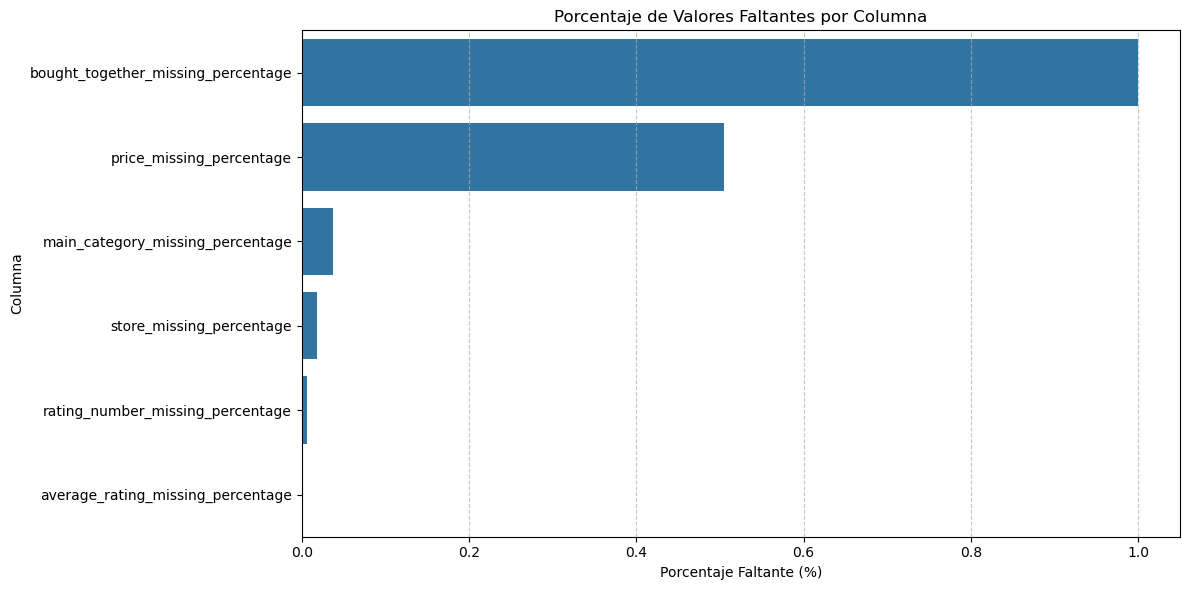

In [12]:
# Comentario: Verificar si el DataFrame df_final existe antes de proceder con el EDA.
if 'df_final' in locals() and df_final is not None:
    print("\n--- EDA: Análisis de Valores Faltantes ---")

    # Comentario: Calcular el porcentaje de valores nulos para cada columna usando Polars.
    # Se utiliza el API lazy para optimización y se recolecta el resultado.
    # pl.len() es la forma eficiente y moderna de contar el número total de filas.
    missing_data_polars = df_final.lazy().select([
        (pl.col(c).is_null().sum() / pl.len()).alias(f'{c}_missing_percentage')
        for c in df_final.columns
    ]).collect()

    # Comentario: Transformar el DataFrame de Polars para obtener las columnas como filas
    # y los porcentajes como una columna 'Missing Percentage'.
    # Se usa `unpivot` que es el reemplazo de `melt` en Polars.
    missing_df_long = missing_data_polars.unpivot(
        on=missing_data_polars.columns, # Todas las columnas son variables a "derretir"
        variable_name="Column",
        value_name="Missing Percentage"
    )

    # Comentario: Convertir los porcentajes a float (aunque ya deberían serlo por el cálculo).
    missing_df_long = missing_df_long.with_columns(
        pl.col("Missing Percentage").cast(pl.Float64)
    )

    # Comentario: Filtrar columnas con un porcentaje de valores faltantes mayor que 0.
    missing_df_filtered_polars = missing_df_long.filter(pl.col("Missing Percentage") > 0)

    # Comentario: Ordenar los resultados para una mejor visualización.
    missing_df_sorted_polars = missing_df_filtered_polars.sort("Missing Percentage", descending=True)

    if not missing_df_sorted_polars.is_empty():
        # Comentario: Imprimir los porcentajes de valores faltantes.
        print("\nPorcentaje de valores faltantes por columna (solo columnas con valores faltantes):")
        print(missing_df_sorted_polars)

        # Comentario: Convertir a Pandas DataFrame justo antes de la visualización con Seaborn.
        # Esta conversión es **necesaria** porque las librerías de visualización como Seaborn
        # y Matplotlib operan sobre estructuras de datos de Pandas/NumPy, no directamente sobre Polars DataFrames.
        missing_df_for_plot = missing_df_sorted_polars.to_pandas()

        # Comentario: Crear un gráfico de barras para visualizar los porcentajes de valores faltantes.
        plt.figure(figsize=(12, 6))
        seaborn.barplot(x='Missing Percentage', y='Column', data=missing_df_for_plot)
        plt.title('Porcentaje de Valores Faltantes por Columna')
        plt.xlabel('Porcentaje Faltante (%)')
        plt.ylabel('Columna')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('./Graphics/missing_values_percentage_bar_chart.png')
        plt.show()
    else:
        print("\nNo hay valores faltantes en el DataFrame.")
else:
    print("\nEl DataFrame 'df_final' no existe o está vacío. No se puede realizar el análisis de valores faltantes.")

## Análisis de Columnas Categóricas


--- EDA: Análisis de Columnas Categóricas ---

Conteo de registros por 'origin':
shape: (3, 2)
┌──────────────────────────┬────────┐
│ origin                   ┆ len    │
│ ---                      ┆ ---    │
│ str                      ┆ u32    │
╞══════════════════════════╪════════╡
│ meta_Musical_Instruments ┆ 213593 │
│ meta_Video_Games         ┆ 137269 │
│ meta_Software            ┆ 89251  │
└──────────────────────────┴────────┘


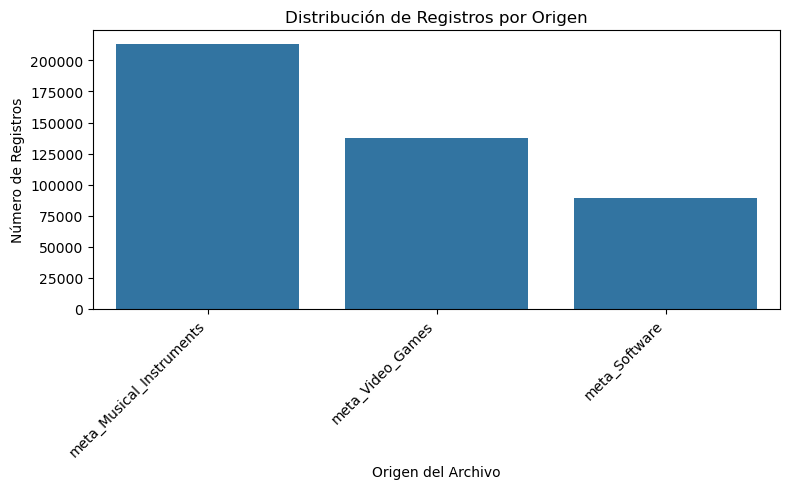


Top 10 'main_category' (categorías principales):
shape: (10, 2)
┌───────────────────────────┬────────┐
│ main_category             ┆ len    │
│ ---                       ┆ ---    │
│ str                       ┆ u32    │
╞═══════════════════════════╪════════╡
│ Musical Instruments       ┆ 183206 │
│ Video Games               ┆ 81298  │
│ Appstore for Android      ┆ 68679  │
│ Software                  ┆ 20943  │
│ All Electronics           ┆ 20819  │
│ Computers                 ┆ 17983  │
│ null                      ┆ 16196  │
│ Industrial & Scientific   ┆ 5009   │
│ Cell Phones & Accessories ┆ 4599   │
│ Toys & Games              ┆ 3795   │
└───────────────────────────┴────────┘


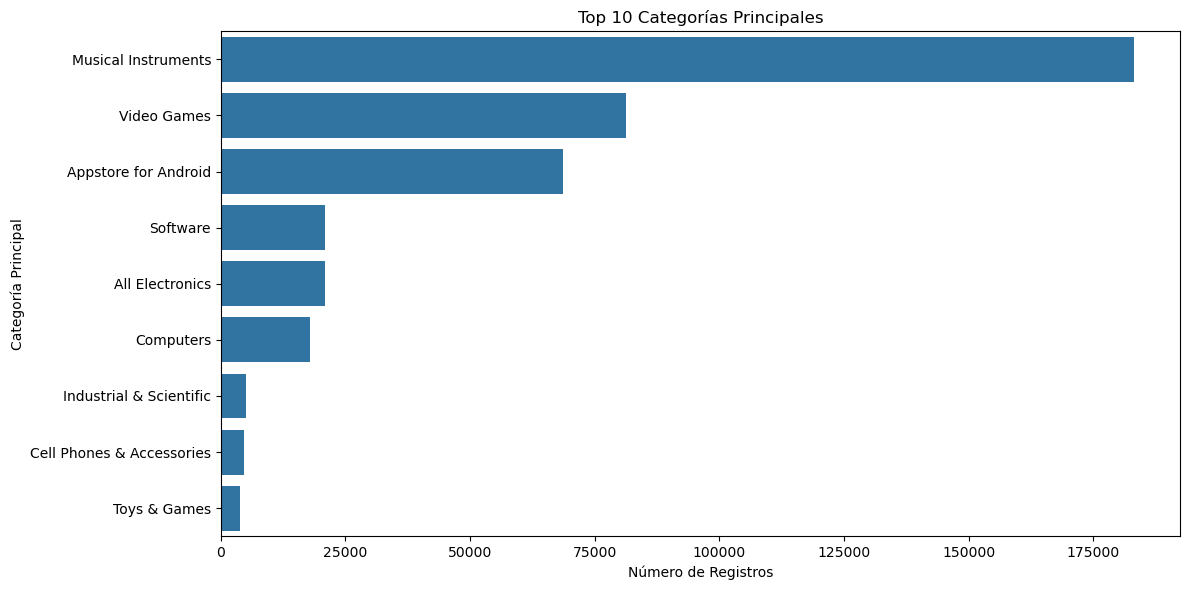


Top 10 'store' (tiendas con más registros):
shape: (10, 2)
┌─────────────────┬──────┐
│ store           ┆ len  │
│ ---             ┆ ---  │
│ str             ┆ u32  │
╞═════════════════╪══════╡
│ null            ┆ 8130 │
│ Nintendo        ┆ 4231 │
│ Fender          ┆ 3969 │
│ Amazon Renewed  ┆ 3672 │
│ Electronic Arts ┆ 2644 │
│ Microsoft       ┆ 2584 │
│ YAMAHA          ┆ 2211 │
│ Sony            ┆ 2183 │
│ Ubisoft         ┆ 1898 │
│ SEGA            ┆ 1843 │
└─────────────────┴──────┘


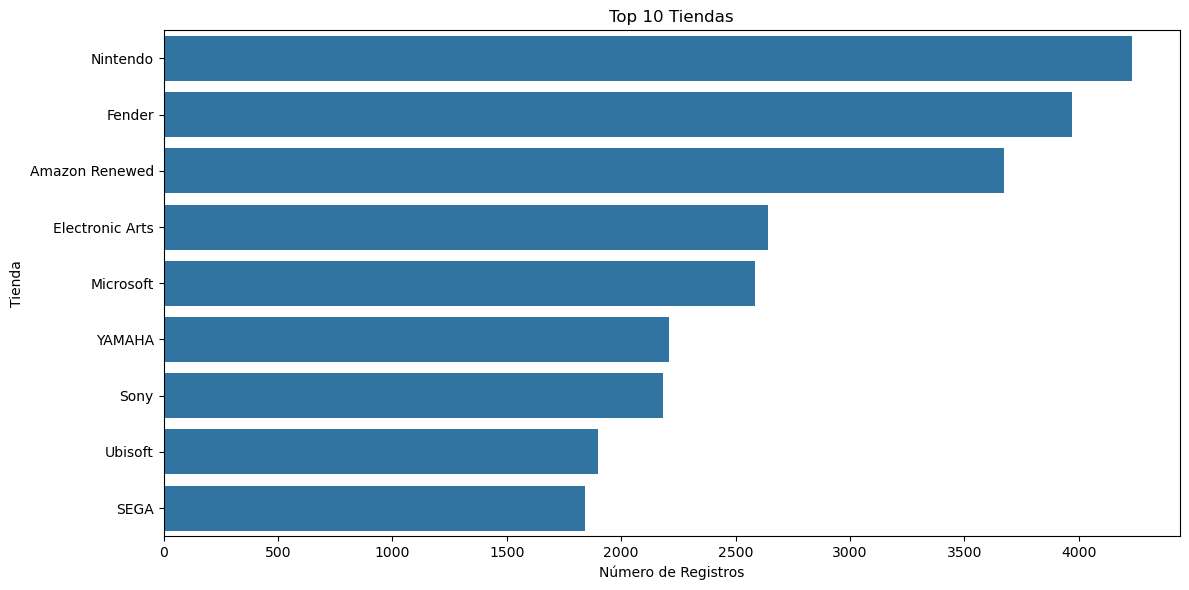

In [14]:
if 'df_final' in locals() and df_final is not None:
    print("\n--- EDA: Análisis de Columnas Categóricas ---")

    # Comentario: Análisis de la columna 'origin'. Ya se mostró en la carga, pero se repite por completitud del EDA.
    print("\nConteo de registros por 'origin':")
    origin_counts = df_final.group_by("origin").len().sort("len", descending=True)
    print(origin_counts)

    # Comentario: Visualizar el conteo de 'origin'.
    plt.figure(figsize=(8, 5))
    seaborn.barplot(x='origin', y='len', data=origin_counts.to_pandas())
    plt.title('Distribución de Registros por Origen')
    plt.xlabel('Origen del Archivo')
    plt.ylabel('Número de Registros')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('./Graphics/origin_distribution_bar_chart.png')
    plt.show()

    # Comentario: Análisis de la columna 'main_category'.
    # Calcular el conteo de cada categoría principal y mostrar las top 10.
    print("\nTop 10 'main_category' (categorías principales):")
    main_category_counts = df_final.group_by("main_category").len().sort("len", descending=True).limit(10)
    print(main_category_counts)

    # Comentario: Visualizar las top 10 'main_category'.
    plt.figure(figsize=(12, 6))
    seaborn.barplot(x='len', y='main_category', data=main_category_counts.to_pandas())
    plt.title('Top 10 Categorías Principales')
    plt.xlabel('Número de Registros')
    plt.ylabel('Categoría Principal')
    plt.tight_layout()
    plt.savefig('./Graphics/main_category_top_10_bar_chart.png')
    plt.show()

    # Comentario: Análisis de la columna 'store'.
    # Calcular el conteo de cada tienda y mostrar las top 10.
    print("\nTop 10 'store' (tiendas con más registros):")
    store_counts = df_final.group_by("store").len().sort("len", descending=True).limit(10)
    print(store_counts)

    # Comentario: Visualizar las top 10 'store'.
    plt.figure(figsize=(12, 6))
    seaborn.barplot(x='len', y='store', data=store_counts.to_pandas())
    plt.title('Top 10 Tiendas')
    plt.xlabel('Número de Registros')
    plt.ylabel('Tienda')
    plt.tight_layout()
    plt.savefig('./Graphics/store_top_10_bar_chart.png')
    plt.show()

else:
    print("\nEl DataFrame 'df_final' no existe o está vacío. No se puede realizar el análisis de columnas categóricas.")

## Análisis de Columnas Numéricas


--- EDA: Análisis de Columnas Numéricas ---


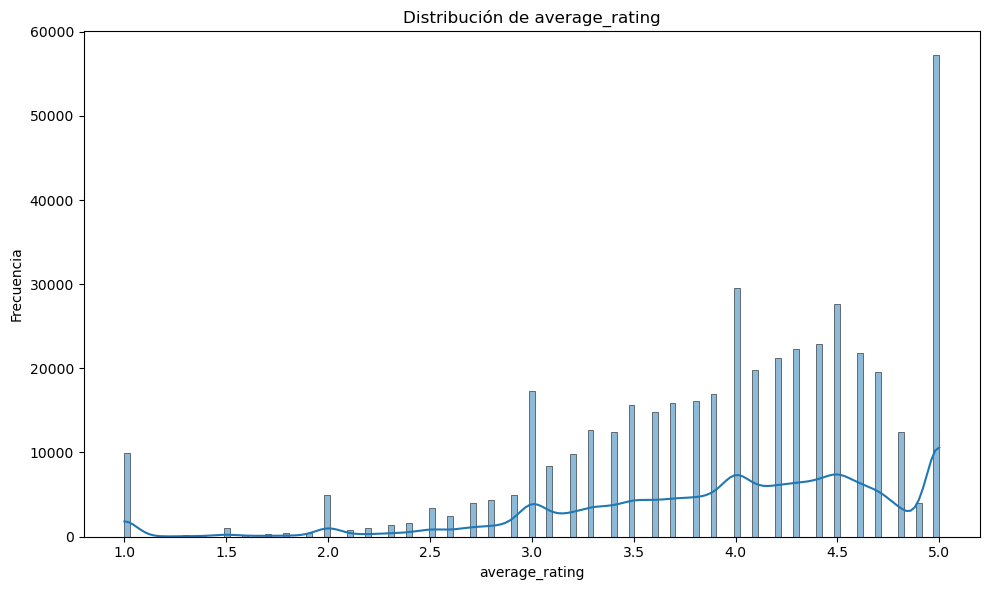

In [ ]:
if 'df_final' in locals() and df_final is not None:
    print("\n--- EDA: Análisis de Columnas Numéricas ---")

    numeric_cols = ["average_rating", "rating_number", "price"]

    # Comentario: Generar histogramas para las columnas numéricas para visualizar sus distribuciones.
    # Los bins se ajustan automáticamente. Se manejan los valores nulos en el ploteo.
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        # Se convierte la serie Polars a Pandas para usar Seaborn.
        # Se filtran los valores nulos para el histograma, ya que Seaborn no los maneja automáticamente.
        data_for_plot = df_final.select(pl.col(col)).filter(pl.col(col).is_not_null()).to_series().to_pandas()
        if not data_for_plot.empty:
            seaborn.histplot(data_for_plot, kde=True)
            plt.title(f'Distribución de {col}')
            plt.xlabel(col)
            plt.ylabel('Frecuencia')
            plt.tight_layout()
            plt.savefig(f'./Graphics/{col}_distribution_hist.png')
            plt.show()
        else:
            print(f"La columna '{col}' no tiene datos no nulos para graficar su distribución.")

    # Comentario: Generar box plots para las columnas numéricas para visualizar la mediana, cuartiles y outliers.
    for col in numeric_cols:
        plt.figure(figsize=(8, 5))
        data_for_plot = df_final.select(pl.col(col)).filter(pl.col(col).is_not_null()).to_series().to_pandas()
        if not data_for_plot.empty:
            seaborn.boxplot(y=data_for_plot)
            plt.title(f'Box Plot de {col}')
            plt.ylabel(col)
            plt.tight_layout()
            plt.savefig(f'./Graphics/{col}_boxplot.png')
            plt.show()
        else:
            print(f"La columna '{col}' no tiene datos no nulos para graficar su box plot.")

    # Comentario: Calcular y visualizar la matriz de correlación entre las columnas numéricas.
    # Esto ayuda a entender las relaciones lineales entre las variables.
    # Se convierte el DataFrame Polars a Pandas para el cálculo de correlación de Seaborn.
    numeric_df_for_corr = df_final.select(numeric_cols).to_pandas()
    correlation_matrix = numeric_df_for_corr.corr()

    if not correlation_matrix.empty:
        plt.figure(figsize=(8, 7))
        seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Matriz de Correlación de Columnas Numéricas')
        plt.tight_layout()
        plt.savefig('./Graphics/numerical_correlation_heatmap.png')
        plt.show()
    else:
        print("\nNo hay suficientes columnas numéricas no nulas para calcular la matriz de correlación.")

else:
    print("\nEl DataFrame 'df_final' no existe o está vacío. No se puede realizar el análisis de columnas numéricas.")

## Análisis de Columnas Numéricas

In [ ]:
# Celda 4: Análisis de Columnas Numéricas

if 'df_final' in locals() and df_final is not None:
    print("\n--- EDA: Análisis de Columnas Numéricas ---")

    numeric_cols = ["average_rating", "rating_number", "price"]

    # Comentario: Generar histogramas para las columnas numéricas para visualizar sus distribuciones.
    # Los bins se ajustan automáticamente. Se manejan los valores nulos en el ploteo.
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        # Se convierte la serie Polars a Pandas para usar Seaborn.
        # Se filtran los valores nulos para el histograma, ya que Seaborn no los maneja automáticamente.
        data_for_plot = df_final.select(pl.col(col)).filter(pl.col(col).is_not_null()).to_series().to_pandas()
        if not data_for_plot.empty:
            seaborn.histplot(data_for_plot, kde=True)
            plt.title(f'Distribución de {col}')
            plt.xlabel(col)
            plt.ylabel('Frecuencia')
            plt.tight_layout()
            plt.savefig(f'./Graphics/{col}_distribution_hist.png')
            plt.show()
        else:
            print(f"La columna '{col}' no tiene datos no nulos para graficar su distribución.")

    # Comentario: Generar box plots para las columnas numéricas para visualizar la mediana, cuartiles y outliers.
    for col in numeric_cols:
        plt.figure(figsize=(8, 5))
        data_for_plot = df_final.select(pl.col(col)).filter(pl.col(col).is_not_null()).to_series().to_pandas()
        if not data_for_plot.empty:
            seaborn.boxplot(y=data_for_plot)
            plt.title(f'Box Plot de {col}')
            plt.ylabel(col)
            plt.tight_layout()
            plt.savefig(f'./Graphics/{col}_boxplot.png')
            plt.show()
        else:
            print(f"La columna '{col}' no tiene datos no nulos para graficar su box plot.")

    # Comentario: Calcular y visualizar la matriz de correlación entre las columnas numéricas.
    # Esto ayuda a entender las relaciones lineales entre las variables.
    # Se convierte el DataFrame Polars a Pandas para el cálculo de correlación de Seaborn.
    numeric_df_for_corr = df_final.select(numeric_cols).to_pandas()
    correlation_matrix = numeric_df_for_corr.corr()

    if not correlation_matrix.empty:
        plt.figure(figsize=(8, 7))
        seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Matriz de Correlación de Columnas Numéricas')
        plt.tight_layout()
        plt.savefig('./Graphics/numerical_correlation_heatmap.png')
        plt.show()
    else:
        print("\nNo hay suficientes columnas numéricas no nulas para calcular la matriz de correlación.")

else:
    print("\nEl DataFrame 'df_final' no existe o está vacío. No se puede realizar el análisis de columnas numéricas.")

## Análisis de Columnas de Lista/Complejas

In [ ]:
if 'df_final' in locals() and df_final is not None:
    print("\n--- EDA: Análisis de Columnas de Lista/Complejas ---")

    # Comentario: Análisis de la longitud de las listas.
    # Calcular la longitud promedio y máxima de las listas en columnas como features, description, categories, bought_together.
    list_cols_lengths = df_final.lazy().select([
        pl.col("features").list.len().alias("features_count"),
        pl.col("description").list.len().alias("description_count"),
        pl.col("categories").list.len().alias("categories_count"),
        pl.col("bought_together").list.len().alias("bought_together_count"),
        pl.col("images").list.len().alias("images_count"), # Número de imágenes por producto
        pl.col("videos").list.len().alias("videos_count")   # Número de videos por producto
    ]).collect()

    print("\nEstadísticas de la longitud de las listas:")
    print(list_cols_lengths.describe())

    # Comentario: Explorar el número de elementos únicos en las columnas de lista (ej. categorías).
    # Para datasets muy grandes, el `explode` puede consumir mucha memoria.
    # Se usará lazy para optimizar y luego se colecta.
    print("\nConteo de elementos únicos en 'categories' (Top 10):")
    # Explode la lista de categorías para contar cada categoría individualmente.
    # Luego agrupa y cuenta las ocurrencias de cada categoría.
    unique_categories = df_final.lazy().select("categories").explode("categories").group_by("categories").len().sort("len", descending=True).limit(10).collect()
    print(unique_categories)

    # Comentario: Explorar las claves dentro de la columna 'details' (si es un Struct).
    # Obtener todas las claves únicas que aparecen en el diccionario 'details'.
    # Esto puede ser intensivo si 'details' es muy variado.
    print("\nExploración de las claves en la columna 'details':")
    # Si 'details' es un Struct, podemos obtener sus campos.
    try:

        # Si el schema ya está inferido para 'details', podemos ver las sub-columnas:
        if 'details' in df_final.schema and isinstance(df_final.schema['details'], pl.Struct):
            details_fields = df_final.schema['details'].fields
            if details_fields:
                print(f"Campos inferidos en 'details' (Struct): {[f.name for f in details_fields]}")
            else:
                print("'details' es un Struct, pero no se infirieron campos específicos (puede estar vacío o muy inconsistente).")
        else:
            print("La columna 'details' no es un tipo Struct como se esperaba o está vacía.")

    except Exception as e:
        print(f"Error al explorar la columna 'details': {e}")
        print("Puede que la estructura de 'details' sea demasiado inconsistente para una exploración directa como Struct.")
        print("Considera convertir 'details' a pl.Utf8 en el esquema y luego usar .str.json_decode() con `pl.col().explode()` para explorar sus claves.")

else:
    print("\nEl DataFrame 'df_final' no existe o está vacío. No se puede realizar el análisis de columnas de lista/complejas.")

## Relaciones entre Columnas

In [ ]:
if 'df_final' in locals() and df_final is not None:
    print("\n--- EDA: Análisis de Relaciones entre Columnas ---")

    # Comentario: Relación entre 'average_rating' y 'price' (gráfica de dispersión).
    # Se filtran nulos para una mejor visualización. Para datasets muy grandes, considera un muestreo.
    print("\nGráfico de dispersión: average_rating vs price")
    data_for_plot = df_final.select(["average_rating", "price"]).filter(pl.col("average_rating").is_not_null() & pl.col("price").is_not_null()).to_pandas()
    if not data_for_plot.empty:
        plt.figure(figsize=(10, 7))
        seaborn.scatterplot(x='price', y='average_rating', data=data_for_plot, alpha=0.5, hue='average_rating', size='average_rating', sizes=(20, 200), legend='brief')
        plt.title('Calificación Promedio vs. Precio')
        plt.xlabel('Precio')
        plt.ylabel('Calificación Promedio')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig('./Graphics/rating_vs_price_scatter.png')
        plt.show()
    else:
        print("No hay datos suficientes para graficar 'average_rating' vs 'price'.")


    # Comentario: Relación entre 'rating_number' y 'average_rating' (gráfica de dispersión).
    print("\nGráfico de dispersión: rating_number vs average_rating")
    data_for_plot = df_final.select(["rating_number", "average_rating"]).filter(pl.col("rating_number").is_not_null() & pl.col("average_rating").is_not_null()).to_pandas()
    if not data_for_plot.empty:
        plt.figure(figsize=(10, 7))
        seaborn.scatterplot(x='rating_number', y='average_rating', data=data_for_plot, alpha=0.5, hue='average_rating', size='rating_number', sizes=(20, 200), legend='brief')
        plt.title('Número de Calificaciones vs. Calificación Promedio')
        plt.xlabel('Número de Calificaciones')
        plt.ylabel('Calificación Promedio')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig('./Graphics/rating_number_vs_average_rating_scatter.png')
        plt.show()
    else:
        print("No hay datos suficientes para graficar 'rating_number' vs 'average_rating'.")

    # Comentario: Calificación promedio por 'main_category' (box plot o barras de media).
    # Se agrupa por categoría principal y se calcula la media de la calificación promedio.
    print("\nCalificación promedio por 'main_category' (Top 10):")
    avg_rating_by_category = df_final.lazy().group_by("main_category").agg(
        pl.col("average_rating").mean().alias("avg_rating")
    ).sort("avg_rating", descending=True).limit(10).collect()
    print(avg_rating_by_category)

    # Visualizar las calificaciones promedio por categoría.
    if not avg_rating_by_category.is_empty():
        plt.figure(figsize=(12, 7))
        seaborn.barplot(x='avg_rating', y='main_category', data=avg_rating_by_category.to_pandas())
        plt.title('Calificación Promedio por Categoría Principal (Top 10)')
        plt.xlabel('Calificación Promedio')
        plt.ylabel('Categoría Principal')
        plt.tight_layout()
        plt.savefig('./Graphics/avg_rating_by_main_category_bar.png')
        plt.show()
    else:
        print("No hay suficientes datos para graficar la calificación promedio por categoría.")

    # Comentario: Distribución de 'price' por 'main_category' (box plot).
    # Esto ayuda a ver cómo varían los precios dentro de diferentes categorías.
    # Se limita a las top N categorías para evitar un gráfico sobrecargado.
    print("\nDistribución de Precio por 'main_category' (Top 5 categorías por número de registros):")
    # Obtener las 5 categorías principales para un boxplot más manejable.
    top_5_categories = df_final.group_by("main_category").len().sort("len", descending=True).limit(5).select("main_category").to_series().to_list()

    if top_5_categories:
        # Filtrar el DataFrame para incluir solo las top 5 categorías.
        df_filtered_by_category = df_final.filter(pl.col("main_category").is_in(top_5_categories))

        # Convertir a Pandas para el boxplot de Seaborn.
        data_for_plot = df_filtered_by_category.select(["main_category", "price"]).filter(pl.col("price").is_not_null()).to_pandas()

        if not data_for_plot.empty:
            plt.figure(figsize=(14, 8))
            seaborn.boxplot(x='main_category', y='price', data=data_for_plot)
            plt.title('Distribución de Precio por Categoría Principal')
            plt.xlabel('Categoría Principal')
            plt.ylabel('Precio')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig('./Graphics/price_distribution_by_main_category_boxplot.png')
            plt.show()
        else:
            print("No hay datos de precio no nulos para las categorías principales seleccionadas.")
    else:
        print("No se pudieron determinar las categorías principales para el box plot de precio.")

else:
    print("\nEl DataFrame 'df_final' no existe o está vacío. No se puede realizar el análisis de relaciones entre columnas.")